This example shows you how to use the reader to read in, pre-process and reconstruct a single slice. It then does the same on the full dataset. It is not intended to be used as an optimised script, but it should demonstrate how to use CIL to get going.

Import the python modules we need

In [1]:
from cil.framework import ImageGeometry
from cil.utilities.jupyter import islicer
from cil.utilities.display import show2D, show_geometry
from cil.processors import CentreOfRotationCorrector, TransmissionAbsorptionConverter, RingRemover
from cil.recon import FBP
from cil.io import NEXUSDataWriter
import numpy as np
import os
import hdf5plugin

from scripts.ESRF_ID15_DataReader import ESRF_ID15_DataReader
from scripts.WeightDuplicateAngles import WeightDuplicateAngles

Set the path to the master hdf5 file and create a reader

In [2]:
filename = '/data/ESRF/test_data/PC811_1000cycles_absct_final_0001.h5'
reader = ESRF_ID15_DataReader(filename)

You can get the geometry of the scan using `get_geomerty()` as default it'll return the combined geometry. You can pass either scan `dataset_id=1` or `dataset_id=2`to get the individual scans

3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [0., 0., 0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [2560  960]
	Pixel size: [1. 1.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 3200
	Angles 0-20 in degrees:
[0.05950433, 0.17946315, 0.29948136, 0.41944018, 0.53951776, 0.65947664,
 0.7795542 , 0.89951307, 1.0194719 , 1.1395495 , 1.2595083 , 1.3794671 ,
 1.4995447 , 1.6195035 , 1.7395217 , 1.85954   , 1.9794987 , 2.0994575 ,
 2.219535  , 2.339494  ]
Distances in units: units distance


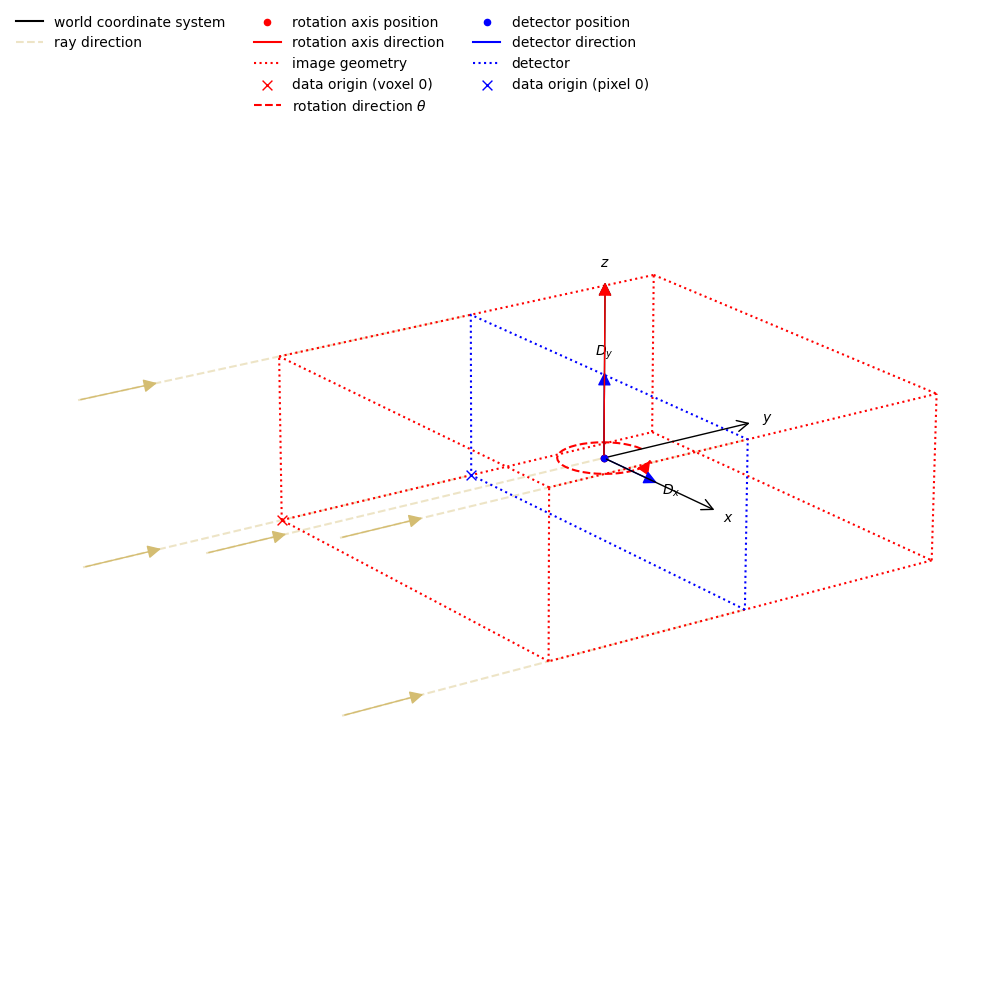

In [3]:
geometry = reader.get_geometry()

print(geometry)

show_geometry(geometry)

You can further configure the reader by setting a region of interest `reader.set_roi()`. Currently you can set only a single slice vertically. This will be expanded in the future. Here we set a single slice and check the geometry.


In [4]:
slice_index = 400
reader.set_roi(vertical=slice_index)
print(reader.get_geometry())

2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0., 0.]
	Detector position: [0., 0.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [2560    1]
	Pixel size: [1. 1.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 3200
	Angles 0-20 in degrees:
[0.05950433, 0.17946315, 0.29948136, 0.41944018, 0.53951776, 0.65947664,
 0.7795542 , 0.89951307, 1.0194719 , 1.1395495 , 1.2595083 , 1.3794671 ,
 1.4995447 , 1.6195035 , 1.7395217 , 1.85954   , 1.9794987 , 2.0994575 ,
 2.219535  , 2.339494  ]
Distances in units: units distance


Now we can read in the data using `reader.read()` as we have set  region of interest we will read only this slice. Again you can specify which dataset with `dataset_id` but the default or `None` will return the combined data.

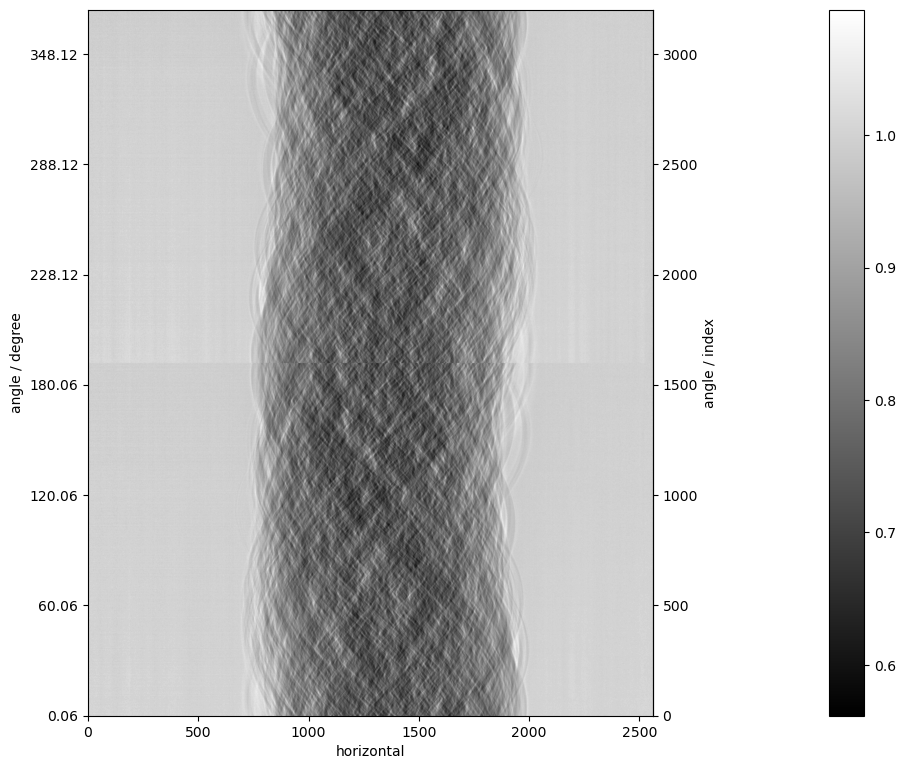

In [5]:
data = reader.read(dataset_id=None)
show2D(data)

We can use `TransmissionAbsorptionConverter` to take the -log to convert the data to absorption, we overwrite the original data.

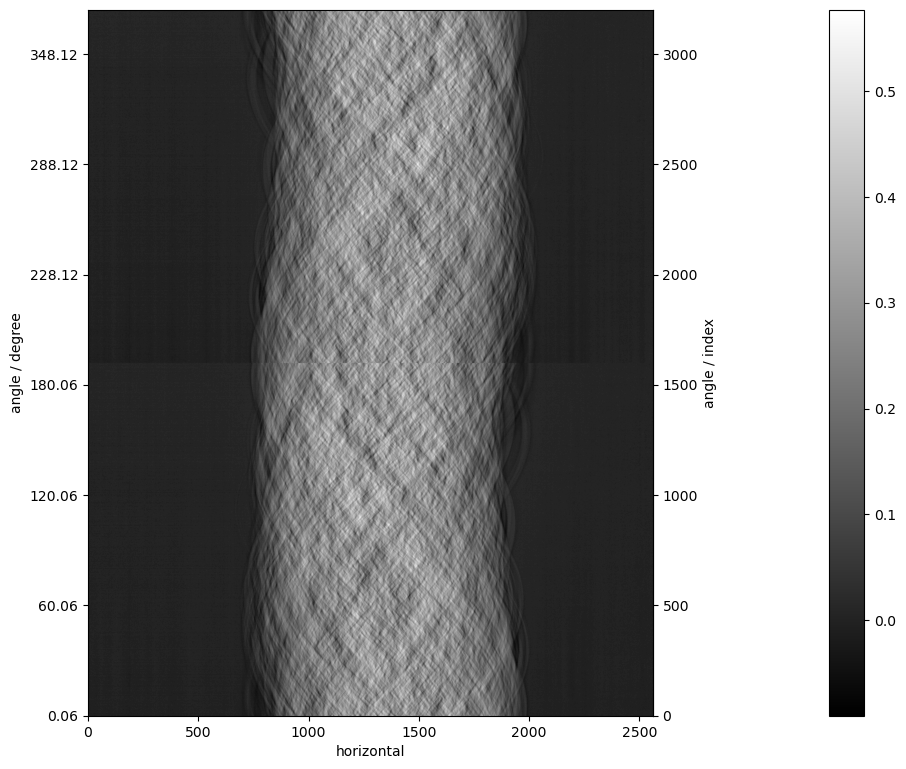

In [6]:
processor = TransmissionAbsorptionConverter()
processor.set_input(data)
processor.get_output(out=data)
show2D(data)

We centre the dataset. This updates the meta data and is used in the reconstruction. The input data is not padded or cropped. This allows sub pixel offsets. Here we can print the geometry and see `Rotation axis position` has an x component of `+83.78`

In [7]:
processor = CentreOfRotationCorrector.xcorrelation()
processor.set_input(data)
processor.get_output(out=data)

print(data.geometry)

2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [83.79,  0.  ]
	Detector position: [0., 0.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [2560    1]
	Pixel size: [1. 1.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 3200
	Angles 0-20 in degrees:
[0.05950433, 0.17946315, 0.29948136, 0.41944018, 0.53951776, 0.65947664,
 0.7795542 , 0.89951307, 1.0194719 , 1.1395495 , 1.2595083 , 1.3794671 ,
 1.4995447 , 1.6195035 , 1.7395217 , 1.85954   , 1.9794987 , 2.0994575 ,
 2.219535  , 2.339494  ]
Distances in units: units distance


To reconstruct a slice we create an FBP reconstructor with the dataset and call `run()`

FBP recon

Input Data:
	angle: 3200
	horizontal: 2560

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



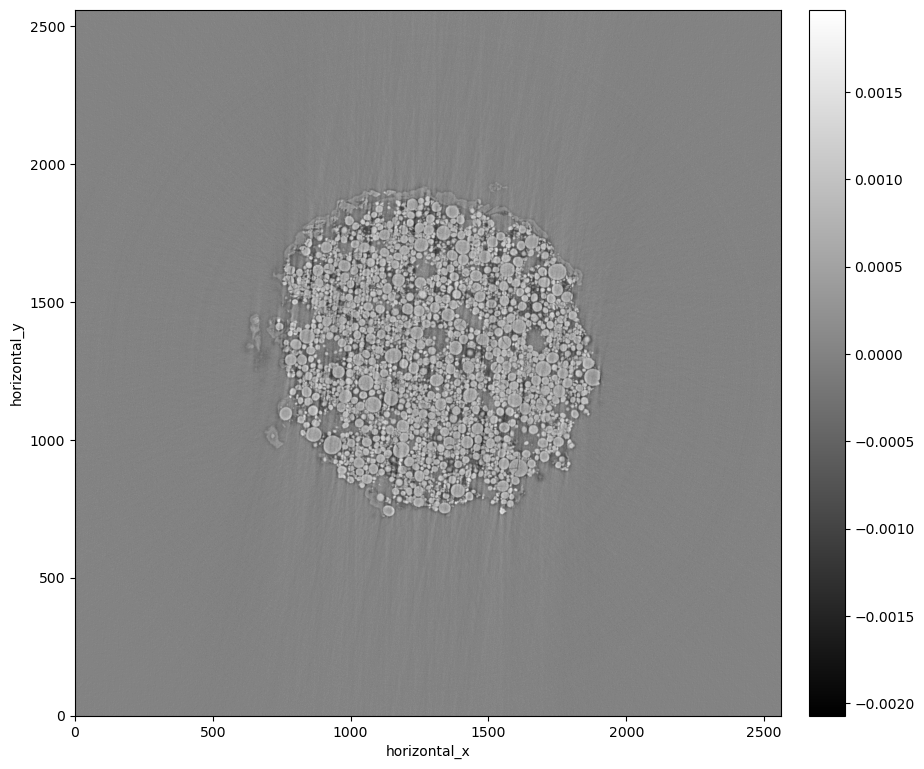

In [8]:
reco = FBP(data).run()
show2D(reco)

We can set the reconstruction window to remove empty space and shift the object to the centre of the window.

FBP recon

Input Data:
	angle: 3200
	horizontal: 2560

Reconstruction Volume:
	horizontal_y: 1500
	horizontal_x: 1500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



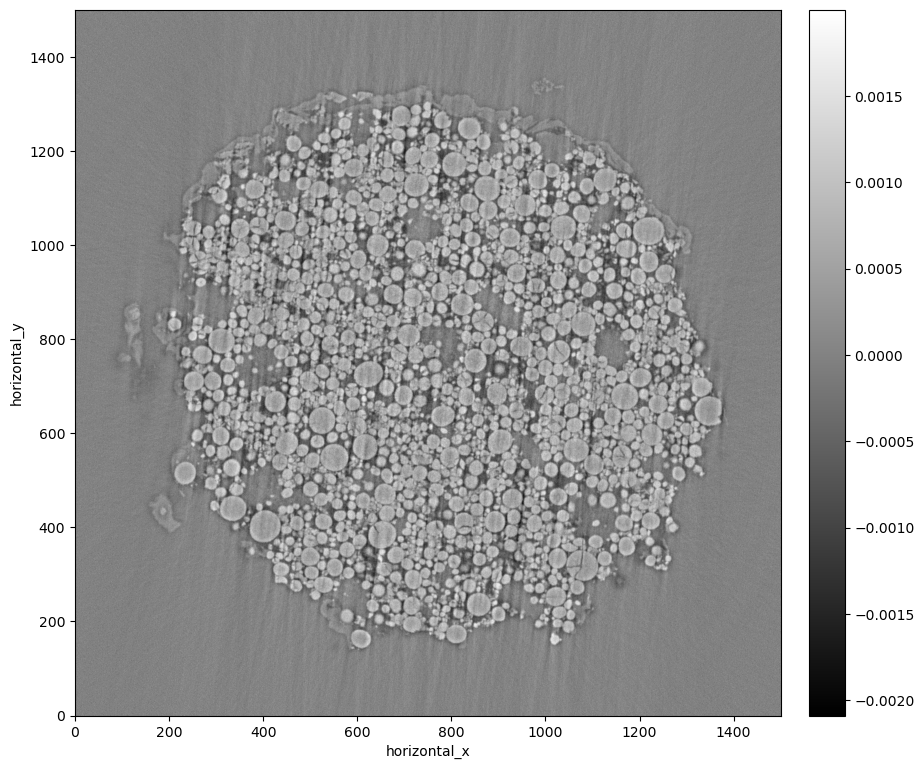

In [9]:
ig_slice = ImageGeometry(voxel_num_x=1500, voxel_num_y=1500, center_x=0, center_y=50)
reco = FBP(data, ig_slice).run()
show2D(reco)

We have some angles with double the data so we see artifacts. We can find the duplicate angles and weight them appropriately for FBP. Using `weight_duplicate_angles` from `weight_duplicate_angles.py`

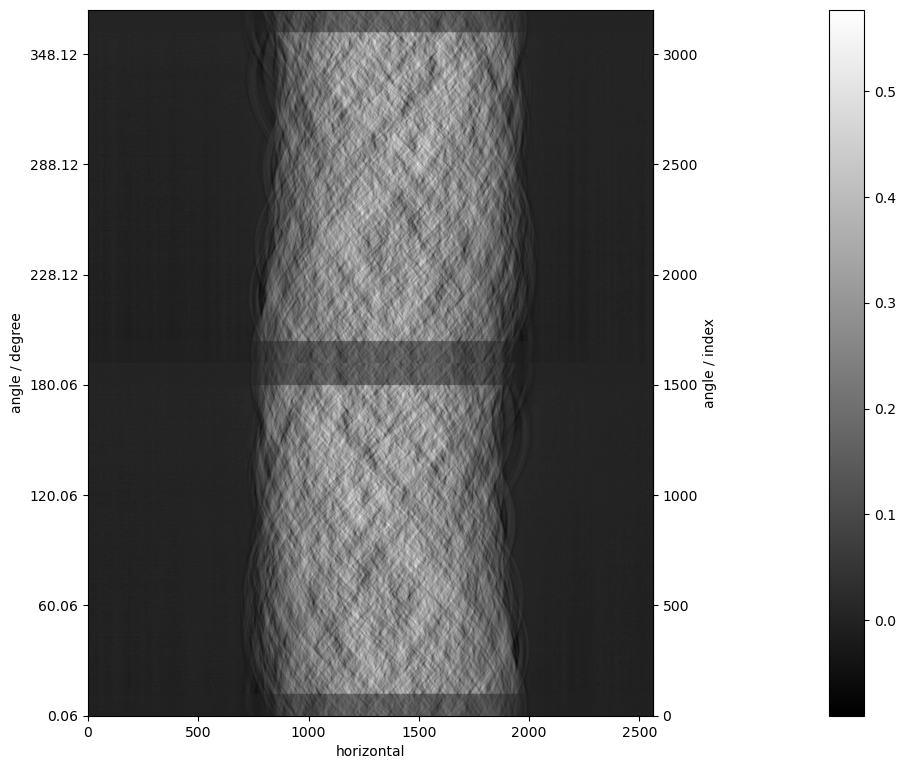

In [10]:
processor = WeightDuplicateAngles()
processor.set_input(data)
processor.get_output(out=data)

show2D(data)

And now we reconstruct the corrected data

FBP recon

Input Data:
	angle: 3200
	horizontal: 2560

Reconstruction Volume:
	horizontal_y: 1500
	horizontal_x: 1500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



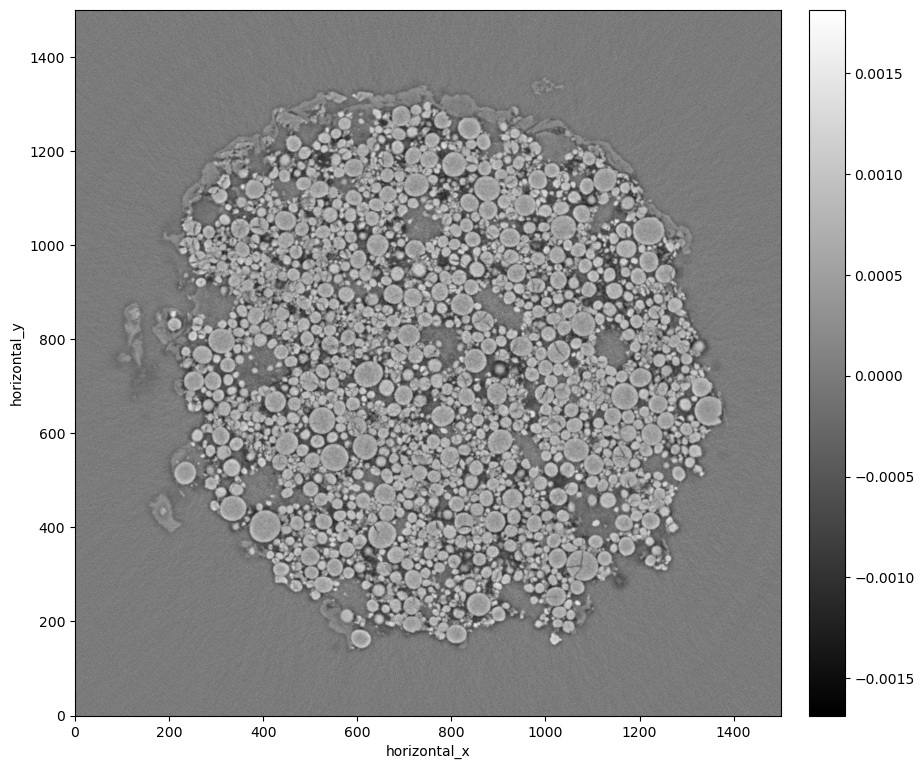

In [11]:
ig_slice = ImageGeometry(1500, 1500, center_x=0, center_y=50)
reco = FBP(data, ig_slice).run()
show2D(reco)

Ring Removal block using the CIL RingRemover

Finish Ring Remover


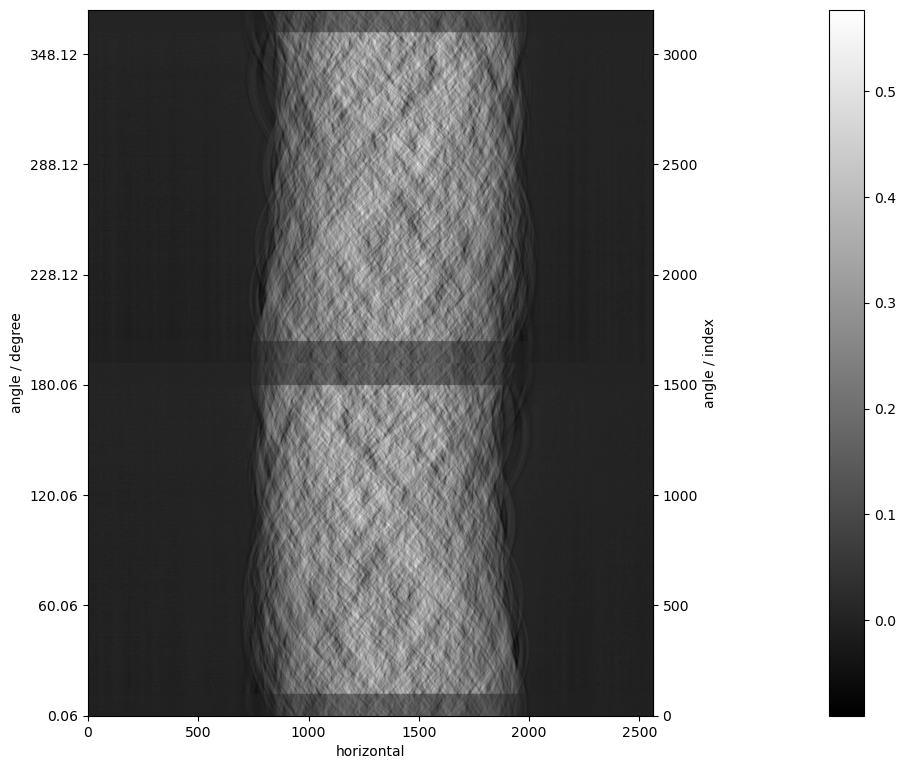

In [12]:
processor = RingRemover(decNum = 4, wname = "db25", sigma = 1.5,  info = True)
processor.set_input(data)
processor.get_output(out=data)
show2D(data)

Check the reconstruction after ring removal

FBP recon

Input Data:
	angle: 3200
	horizontal: 2560

Reconstruction Volume:
	horizontal_y: 1500
	horizontal_x: 1500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



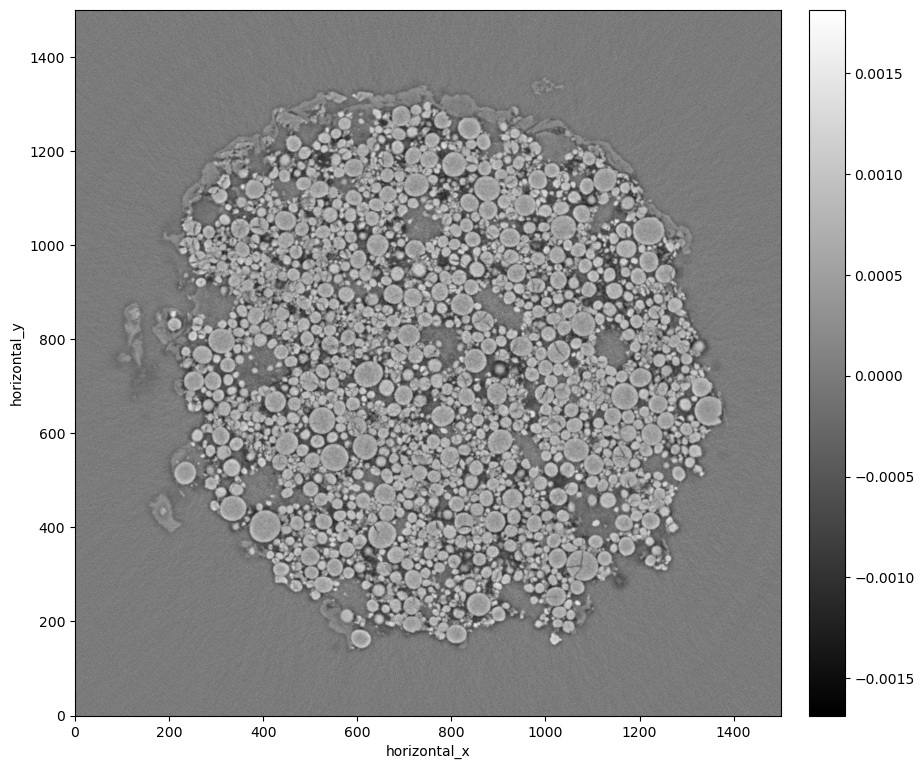

In [13]:
ig_slice = ImageGeometry(1500, 1500, center_x=0, center_y=50)
reco = FBP(data, ig_slice).run()
show2D(reco)

Look at some close details of the reconstruction

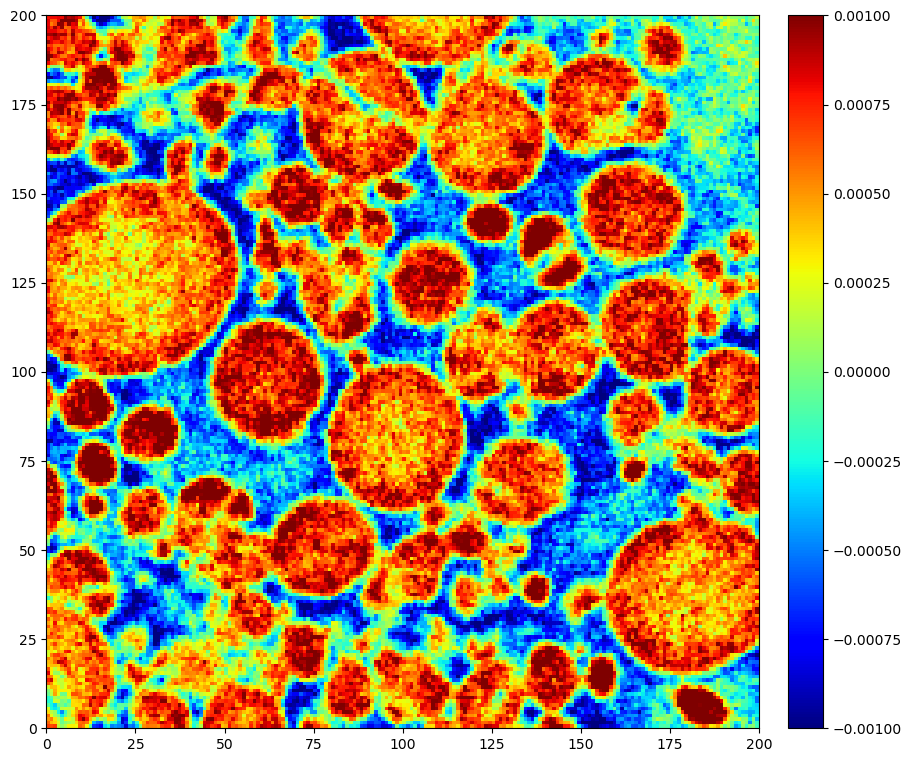

In [14]:
show2D(reco.array[600:800, 600:800], cmap = "jet", fix_range = (-0.001, 0.001))

# Processing the full dataset

read in the full dataset by resetting the region of interest in the reader. Then we read it in as before with `reader.read()`

In [15]:
reader.set_roi(None)
data = reader.read()

We can view the data interactively using `islicer`, by default we scroll through `angles`

In [16]:
islicer(data, origin='upper-left', size=10)

We call the processors on the dataset using their short form:

In [17]:
TransmissionAbsorptionConverter()(data, out=data)
CentreOfRotationCorrector.xcorrelation(slice_index=slice_index)(data, out = data)
WeightDuplicateAngles()(data, out = data)
RingRemover(decNum = 4, wname = "db25", sigma = 1.5,  info = True)(data, out=data)

Finish Ring Remover


And set up out FBP reconstructor with a custom window:

In [18]:
ig = ImageGeometry(voxel_num_x = 1500, voxel_num_y = 1500, voxel_num_z = 700)
fbp = FBP(data, ig)

Run the reconstructor with `FBP.run()`

In [19]:
reco = fbp.run()

FBP recon

Input Data:
	angle: 3200
	vertical: 960
	horizontal: 2560

Reconstruction Volume:
	vertical: 700
	horizontal_y: 1500
	horizontal_x: 1500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



View the volume using islicer. You can change the slice direction by setting  `direction='vertical'` or `'horizontal_y'` or `'horizontal_x'`

In [20]:
# islicer(reco, direction='vertical', origin='upper-left', size=10)
islicer(reco.array[:, :, :], direction=0, origin='upper-left', size=10, cmap = "bone")

Save the array as a binary:

In [21]:
path_out = os.path.abspath('/data/ESRF/test_data/vol_{0}_{1}_{2}'.format(*reco.shape))
#reco.as_array().astype(np.float32).tofile(path_out + '.raw')

Or as a CIL formatted volume - Nexus is a standard derived from hdf5 so you should be able to access it with your HDF5 file browser:

In [22]:
path_out = os.path.abspath('/data/ESRF/test_data/vol.nxs')
writer = NEXUSDataWriter(data=reco, file_name=path_out, compression=0)
#writer.write()
#%%